In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(1562, 20)
(1562, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_FR_swinging = X_motion[idxs]
Y_motion_FR_swinging = Y_motion[idxs]

## Predict FR foot -> x

In [8]:
X_motion_FR_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.24126466,  0.12416799,
       -0.38245061,  0.23819205, -0.13101307, -0.37997335, -0.25759894,
        0.12540799, -0.38777819, -0.2609376 , -0.12951526, -0.38073996,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ])

In [9]:
Y_motion_FR_swinging[0, :]

array([ 0.02910896, -0.00173677,  0.02596132, -0.00702251])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_FR_swinging[:, -5:-2], # Previous motion command
               X_motion_FR_swinging[:, :3], # Current motion command
               X_motion_FR_swinging[:, 3:5], # FL (x,y) position
               X_motion_FR_swinging[:, 6:8], # FR (x,y) position
               X_motion_FR_swinging[:, 9:11], # RL (x,y) position
               X_motion_FR_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_x = LinearRegression()

# Fit the model
model_fr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9804311073343862
RMSE:  0.01751095839094746
The lowest error is:  1.8337688246994333e-05
The highest error is:  0.10432824031162952
The avg. error is:  0.010687067384457356


In [11]:
model_fr_relative_swinging_x.coef_

array([[ 2.05675074e-02, -1.11022302e-16, -1.11022302e-16,
         2.19132907e-01, -1.11022302e-16,  1.11022302e-16,
         4.68616241e-01, -1.47294861e+00, -1.32181760e+00,
         8.81263120e-01, -7.38832561e-01,  1.72107747e-01,
        -4.90660517e-02,  1.05655314e+00]])

In [12]:
model_fr_relative_swinging_x.intercept_

array([0.42105654])

Text(0, 0.5, 'Predictions')

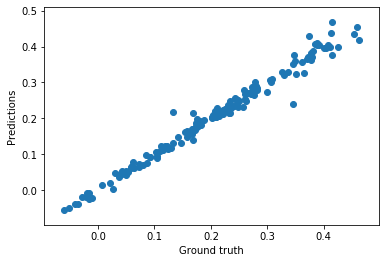

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_fr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_fr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav")

### Predict FL foot -> y

In [17]:
# Input
X = np.hstack((X_motion_FR_swinging[:, -5:-2], # Previous motion command
               X_motion_FR_swinging[:, :3], # Current motion command
               X_motion_FR_swinging[:, 3:5], # FL (x,y) position
               X_motion_FR_swinging[:, 6:8], # FR (x,y) position
               X_motion_FR_swinging[:, 9:11], # RL (x,y) position
               X_motion_FR_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_y = LinearRegression()

# Fit the model
model_fr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.33107910528730233
RMSE:  0.0073670001736087
The lowest error is:  6.890797195285847e-05
The highest error is:  0.02600860777839592
The avg. error is:  0.005615881699857385


In [18]:
model_fr_relative_swinging_y.coef_

array([[ 8.16716731e-03, -9.36750677e-17,  1.31838984e-16,
        -9.47637391e-03,  0.00000000e+00, -1.66533454e-16,
         9.70951400e-02,  3.76339322e-01, -1.20083170e-01,
        -7.77032352e-01,  2.26838811e-01, -1.45441731e+00,
         1.00942212e-02,  3.14341060e-01]])

In [19]:
model_fr_relative_swinging_y.intercept_

array([0.13845567])

Text(0, 0.5, 'Predictions')

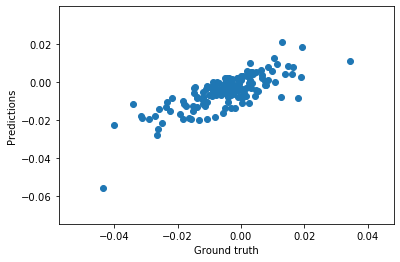

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_fr_relative_swinging_y

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [23]:
# Save model
#joblib.dump(model_fr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav")